In [25]:
from requests import get
import matplotlib.pyplot as plt
import numpy as np


plt.rcParams['axes.linewidth'] = 0.8
plt.style.use('seaborn-deep')
print(plt.style.available)
metric = 'ndcg'
cutoff = '10'
n_questions = 10
de_only = True
experiment_subset = 'uniform'



data = get(f'https://mindreader.tech/spectate/results/{experiment_subset}/{metric}/{cutoff}').json()
metric = metric.replace('cov', 'div')  # Hack job :-)
interviewer_kinds = ['greedy-adaptive-', 'greedy-', 'pop-']#, 'dqn-', 'ddpg-']

def replace_all(string, lst):
    for item in lst:
        string = string.replace(item, '')
    
    return string

unique_models = set([replace_all(model, interviewer_kinds) for model in data.keys()])
if de_only:
    unique_models = set([model.replace('-rec', '') for model in unique_models])
else:
    unique_models = set([model for model in unique_models if model.endswith('-rec')])

print(unique_models)
unique_models = sorted(set([model for model in unique_models if all([f'{interviewer}{model}' in data and len(data[f'{interviewer}{model}']) >= n_questions for interviewer in interviewer_kinds])]))
print(unique_models)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']
{'ppr-linear-learned', 'knn', 'ppr-joint', 'dqn-mf', 'ppr-collab', 'lrmf', 'dqn-ppr-joint', 'ppr-kg', 'ppr-linear-grid', 'fmf', 'mf', 'random', 'dqn-knn', 'top-pop'}
['knn', 'mf', 'ppr-collab', 'ppr-joint', 'ppr-linear-learned']



['knn', 'mf', 'ppr-collab', 'ppr-joint', 'ppr-linear-learned'] [0.33707629060183647, 0.37421586398646, 0.3855777734813358, 0.364654666917953, 0.3687924088079425] [0.0, 0.016093914945693188, 0.016012828997351344, 0.013696275652671992, 0.0]

['knn', 'mf', 'ppr-collab', 'ppr-joint', 'ppr-linear-learned'] [0.3315501227238927, 0.37421586398646, 0.38594095663307315, 0.3738358738770504, 0.375296592480337] [0.0296594004706024, 0.016093914945693188, 0.016016630644674623, 0.015566353289928277, 0.0]

['knn', 'mf', 'ppr-collab', 'ppr-joint', 'ppr-linear-learned'] [0.34352785280373255, 0.37421586398646, 0.3885327609897071, 0.3716072349507849, 0.3747385198352702] [0.024506469123986917, 0.016093914945693188, 0.016046891208050872, 0.016893462141112092, 0.0]


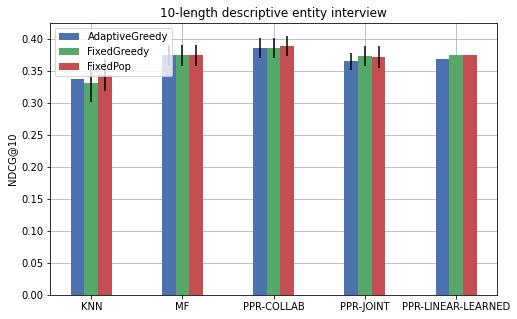

In [26]:
fig, ax = plt.subplots(figsize=(8, 5))
ind = np.arange(len(unique_models))
width = .15

model_map = {'ppr-linear-grid': 'ppr-linear'}
label_map = {'greedy-adaptive-': 'AdaptiveGreedy', 'greedy-': 'FixedGreedy', 'pop-': 'FixedPop', 'dqn-': 'DQN', 'ddpg-': 'DDPG'}
for idx, kind in enumerate(interviewer_kinds):
    x = unique_models
    print()
    y = [np.mean(data[f'{kind}{model}'][n_questions - 1]) for model in x]
    y_std = [np.std(data[f'{kind}{model}'][n_questions - 1]) for model in x]

    print(x, y, y_std)
    ax.bar(ind + idx * width, y, yerr=y_std, width=width, label=label_map.get(kind), zorder=3)
    
model_displays = [model.replace('-rec', '') for model in unique_models]
model_displays = map(lambda model: model_map.get(model, model).upper(), model_displays)

ax.set_xticks(ind + width)
ax.set_xticklabels(model_displays)
plt.ylabel(f'{metric.upper()}@{cutoff}')
interview_kind = 'DE' if de_only else 'RE'
interview_kind_long = 'descriptive' if de_only else 'recommendable'
plt.title(f'{n_questions}-length {interview_kind_long} entity interview')
plt.legend()
plt.grid(True, zorder=0)
plt.savefig(f'output/{experiment_subset}_{interview_kind.lower()}_{metric}{cutoff}_interviewer_comparison.pdf', bbox_inches='tight')
plt.show()